# Create configs:
1) Create a base config file:
    1) Define the covariates dict `COVARS`
    2) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
3) Iteratively increase or decrease a COV_TO_GEN relation and create multiple variations of the base config file.
    1) Define the number of steps of iteration
    2) Define the increment size
3) Test that the config file meets the expectation using `ToyBrainsData(config=...).show_current_config()`
4) Generate the datasets
5) For all covariates, estimate the maximum predictable accuracy from the generative attributes
    1) using linear/logistic regression model with $R^2$/$D^2$ metric for goodness-of-fit respectively.
    2) using SHAP
    3) by evaluating on a no-conf dataset variation and no-true signal dataset variation


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# print date and time
from datetime import datetime
start_time = datetime.now()
print("Notebook started on {}".format(str(start_time).split(".")[0]))

Notebook started on 2024-02-16 16:52:33


In [2]:
# standard python packages
import os, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# from tqdm.notebook import tqdm
from copy import deepcopy
from glob import glob
from tqdm.auto import tqdm

# if parent 'Toybrains' directory is not in path, add it
if os.path.abspath('../../') not in sys.path:
    sys.path.append(os.path.abspath('../../'))

from utils.vizutils import show_contrib_table, viz_contrib_table_2
from utils.configutils import create_config_file, apply_tweak_rules, print_tweaked_rules

KeyboardInterrupt: 

### Dataset generation settings

In [ ]:
N_SAMPLES  = 5000
OVERWRITE_EXISTING = True
GEN_IMAGES = True
VIZ_GENERATED_DISTS = True

GEN_BASELINES = True
METRICS = ['r2','balanced_accuracy', 'roc_auc']
VIZ_BASELINE = True # ensure GEN_BASELINES is True or it is pregenerated

STEPS_TRUE = 5
STEPS_CONF = 5

basefilename = 'lblmidr-consite'
config_dirname = 'configs' #  a folder to save all the configs

Define a simple case with 1 binary confound and 1 binary label:

In [ ]:
# 1) Create a base config file:
#   a) Define the covariates dict `COVARS`
COVARS = {
            'cov_site'   : dict(states=['siteA', 'siteB']),
            'lbl_lesion' : dict(states=[True, False]),
         }
#   b) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
# Rules about which covariate-state influences which generative variables
RULES_COV_TO_GEN = {
    ## (1) c --> X: `siteA -> brain intensity is higher` 
    'cov_site':{
        'siteA':{ 
            'brain-int_fill'  :  dict(weights=(1,1,1,1,1)),
            ## (2) c --> y: `siteA -> more likely to be lesion group` 
            'lbl_lesion' : dict(weights=(1,1))
        },
        'siteB':{
            'brain-int_fill'  : dict(weights=(1,1,1,1,1)),
            ## (2) c --> y: `siteB -> more likely to be control group` 
            'lbl_lesion' : dict(weights=(1,1))
        },
    },
    
    ## (3) X --> y: `lbl_lesion is True -> Volume of mid-right lesion is higher`
    'lbl_lesion':{
        True:{  
            'shape-midr_curv'    :dict(weights=(1,1,1,1,1,1,1,1,1)), 
            'shape-midr_vol-rad' :dict(weights=(1,1,1,1))},
        False:{ 
            'shape-midr_curv'    :dict(weights=(1,1,1,1,1,1,1,1,1)),
            'shape-midr_vol-rad' :dict(weights=(1,1,1,1))},
    },
}

In [ ]:
# ! rm -rf configs/*

In [ ]:
if not os.path.exists(config_dirname):
    os.makedirs(config_dirname)

Sampling image gen. attributes for n=1000 toybrain samples


 21%|██▏       | 214/1000 [00:00<00:01, 538.50it/s]

100%|██████████| 1000/1000 [00:01<00:00, 514.34it/s]


Config file: configs/lblmidr-consite.py


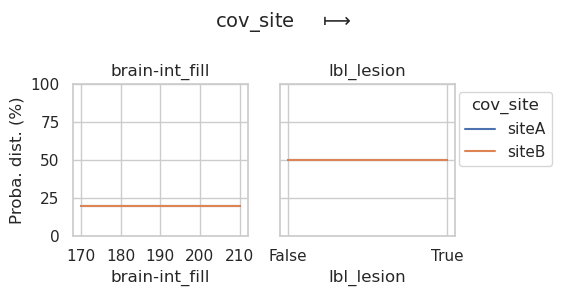

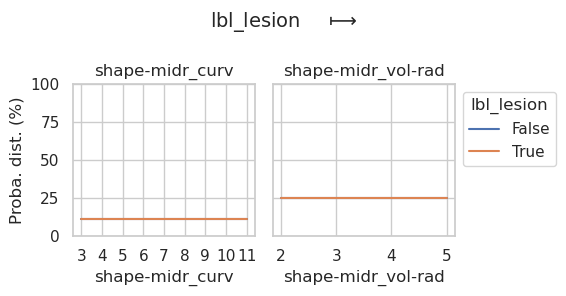

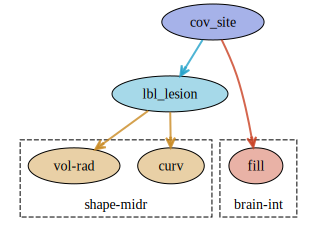

removed 'configs/lblmidr-consite.py'
removed 'dataset/toybrains_n1000_lblmidr-consite/toybrains_n1000_lblmidr-consite.csv'
removed directory 'dataset/toybrains_n1000_lblmidr-consite'


In [ ]:
# first create the base config file
config_fname = f'{config_dirname}/{basefilename}.py'
    
# see the base config file's causal graph
rules = deepcopy(RULES_COV_TO_GEN)
create_config_file(
                config_fname, COVARS, rules, 
                show_dag_probas=True,
                return_baseline_results = False,
                gen_images=0,
                overwrite_existing=True)

# delete the generated config file and dataset
!rm -v $config_fname
!rm -rvf dataset/toybrains_n*$basefilename

### Define rule updates
Now iteratively generate more config files from the base configuration by:
1. Create 5 steps of increasing true association  $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in steps from 0% -> 25%-> 50% -> 75% -> 100% associations.  
2. Create 5 steps of increasing confound association with the attributes $c_{site} \rightarrow a_{brain-int\_fill}$ from 0 to 100% 
3. Create 5 steps of increasing confound correlation with the output  $c_{site} \rightarrow y_{lesion}$ in 5 steps from 0 to 100% 

In total there should be $5 \times 5 \times 5 = 125$ configurations.

In [ ]:
# create a generator that yields 'iter' number of vectors, given the start and the end vector
def linear_interpolate(start, end, iter):
    start = np.array(start)
    end = np.array(end)
    for i in range(iter):
        yield (start + (end-start)*i/(iter-1)).tolist()

In [ ]:
# (1) incrementally increasing $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in 5 steps 
# from 0% association to 100% association
curv_start = (1, 1, 1, 1, 1, 1, 1, 1, 1)
curv_end = (0, 0, 0, 0, 0, 1, 1, 2, 5)
vol_rad_start = (1, 1, 1, 1)
vol_rad_end = (0, 0, 1, 3)


tweak_rules_yX =[
    ['lbl_lesion', True,   'shape-midr_curv',    'weights', list(linear_interpolate(curv_start, curv_end, STEPS_TRUE)            )],
    ['lbl_lesion', False,  'shape-midr_curv',    'weights', list(linear_interpolate(curv_start, curv_end[::-1], STEPS_TRUE)      )],
    ['lbl_lesion', True,   'shape-midr_vol-rad', 'weights', list(linear_interpolate(vol_rad_start, vol_rad_end, STEPS_TRUE)      )],
    ['lbl_lesion', False,  'shape-midr_vol-rad', 'weights', list(linear_interpolate(vol_rad_start, vol_rad_end[::-1], STEPS_TRUE))]
]

# test
print_tweaked_rules(RULES_COV_TO_GEN, tweak_rules_yX, iters=STEPS_TRUE)

--------------------------------------------------
i=0
	 lbl_lesion = True 	--> shape-midr_curv:	 weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
	 lbl_lesion = False 	--> shape-midr_curv:	 weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 weights = [1.0, 1.0, 1.0, 1.0]
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 weights = [1.0, 1.0, 1.0, 1.0]
--------------------------------------------------
i=1
	 lbl_lesion = True 	--> shape-midr_curv:	 weights = [0.75, 0.75, 0.75, 0.75, 0.75, 1.0, 1.0, 1.25, 2.0]
	 lbl_lesion = False 	--> shape-midr_curv:	 weights = [2.0, 1.25, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 weights = [0.75, 0.75, 1.0, 1.5]
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 weights = [1.5, 1.0, 0.75, 0.75]
--------------------------------------------------
i=2
	 lbl_lesion = True 	--> shape-midr_curv:	 weights = [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.5, 3.0]
	 lbl_lesion

In [ ]:
# (2) incrementally increasing partial $c_{site} --> a_{brain-int_fill}$ in 5 steps from 0 to 100%
int_fill_start = (1, 1, 1, 1, 1)
int_fill_end   = (0, 0, 0, 1, 4)

tweak_rules_cX =[
    ['cov_site', 'siteA', 'brain-int_fill', 'weights', list(linear_interpolate(int_fill_start, int_fill_end, STEPS_CONF))],
    ['cov_site', 'siteB', 'brain-int_fill', 'weights', list(linear_interpolate(int_fill_start, int_fill_end[::-1], STEPS_CONF))]
]
print_tweaked_rules(RULES_COV_TO_GEN, tweak_rules_cX, iters=STEPS_CONF)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> brain-int_fill:	 weights = [1.0, 1.0, 1.0, 1.0, 1.0]
	 cov_site = siteB 	--> brain-int_fill:	 weights = [1.0, 1.0, 1.0, 1.0, 1.0]
--------------------------------------------------
i=1
	 cov_site = siteA 	--> brain-int_fill:	 weights = [0.75, 0.75, 0.75, 1.0, 1.75]
	 cov_site = siteB 	--> brain-int_fill:	 weights = [1.75, 1.0, 0.75, 0.75, 0.75]
--------------------------------------------------
i=2
	 cov_site = siteA 	--> brain-int_fill:	 weights = [0.5, 0.5, 0.5, 1.0, 2.5]
	 cov_site = siteB 	--> brain-int_fill:	 weights = [2.5, 1.0, 0.5, 0.5, 0.5]
--------------------------------------------------
i=3
	 cov_site = siteA 	--> brain-int_fill:	 weights = [0.25, 0.25, 0.25, 1.0, 3.25]
	 cov_site = siteB 	--> brain-int_fill:	 weights = [3.25, 1.0, 0.25, 0.25, 0.25]
--------------------------------------------------
i=4
	 cov_site = siteA 	--> brain-int_fill:	 weights = [0.0, 0.0, 0.0, 1.0, 4.0]
	 cov_site = sit

In [ ]:
# (3) incrementally increasing partial $c_{site} --> y_{lesion}$ in 5 steps from 0 to 100% 
lbl_lesion_start = (1, 1)
lbl_lesion_end   = (0, 2)

tweak_rules_cy =[
    ['cov_site', 'siteA', 'lbl_lesion', 'weights', list(linear_interpolate(lbl_lesion_start, lbl_lesion_end, STEPS_CONF))],#lambda x: int((x+1)**2)],
    ['cov_site', 'siteB', 'lbl_lesion', 'weights', list(linear_interpolate(lbl_lesion_start, lbl_lesion_end[::-1], STEPS_CONF))]#lambda x: int((x+1)**2)]
]
print_tweaked_rules(RULES_COV_TO_GEN, tweak_rules_cy, iters=STEPS_CONF)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> lbl_lesion:	 weights = [1.0, 1.0]
	 cov_site = siteB 	--> lbl_lesion:	 weights = [1.0, 1.0]
--------------------------------------------------
i=1
	 cov_site = siteA 	--> lbl_lesion:	 weights = [0.75, 1.25]
	 cov_site = siteB 	--> lbl_lesion:	 weights = [1.25, 0.75]
--------------------------------------------------
i=2
	 cov_site = siteA 	--> lbl_lesion:	 weights = [0.5, 1.5]
	 cov_site = siteB 	--> lbl_lesion:	 weights = [1.5, 0.5]
--------------------------------------------------
i=3
	 cov_site = siteA 	--> lbl_lesion:	 weights = [0.25, 1.75]
	 cov_site = siteB 	--> lbl_lesion:	 weights = [1.75, 0.25]
--------------------------------------------------
i=4
	 cov_site = siteA 	--> lbl_lesion:	 weights = [0.0, 2.0]
	 cov_site = siteB 	--> lbl_lesion:	 weights = [2.0, 0.0]


### Generate all rules

In [ ]:
# os.system(f"rm -rvf dataset/toybrains_n{N_SAMPLES}_{basefilename}_*") # remove the existing dataset

In [ ]:
# collect all the rules
all_rules = []
for cy in range(STEPS_CONF):
    if cy==0: # reset
        rules_cy = deepcopy(RULES_COV_TO_GEN)
    rules_cy = apply_tweak_rules(rules_cy, tweak_rules_cy, cy)

    for cX in range(STEPS_CONF):
        if cX==0: # reset the rules to previous loop's rules
            rules_cX = deepcopy(rules_cy)
        rules_cX = apply_tweak_rules(rules_cX, tweak_rules_cX, cX)

        for yX in range(STEPS_TRUE):
            if yX==0: # reset the rules to previous loop's rules
                rules_yX = deepcopy(rules_cX)
            rules_yX = apply_tweak_rules(rules_yX, tweak_rules_yX, yX)
            # print(f'cy={cy}, cX={cX}, yX={yX}, {rules_yX["lbl_lesion"][True]["shape-midr_curv"]["amt"]}')
            all_rules.append(((cy, cX, yX), deepcopy(rules_yX)))
        

### Generate datasets

In [ ]:
def create_config_file_parallel(cy,cX,yX, rules, 
                                n_samples=N_SAMPLES, 
                                gen_baselines=GEN_BASELINES, metrics=METRICS,
                                gen_images=GEN_IMAGES):
    cy_percent = (100*cy)//(STEPS_CONF-1)
    cX_percent = (100*cX)//(STEPS_CONF-1)
    yX_percent = (100*yX)//(STEPS_TRUE-1)
    config_fname = f'{config_dirname}/{basefilename}_cy{cy_percent:03}-cX{cX_percent:03}-yX{yX_percent:03}.py'
    print(f'Creating dataset with config file {config_fname}')
    
    # TODO: only generate images for one mid subset of settings to save time
    # if gen_images==True and cX==2: 
    #     gen_images = True
    # else:
    #     gen_images = False
        
    bl_result = create_config_file(
                    config_fname, COVARS, rules, 
                    show_dag_probas=False,
                    return_baseline_results=gen_baselines,
                    baseline_metrics=metrics,
                    n_samples=n_samples,
                    gen_images=gen_images,
                    verbose=0,
                    overwrite_existing=OVERWRITE_EXISTING)
    return bl_result

In [ ]:
# test SHAP estimation
# (cy,cX,yX), rules = all_rules[-1]
# results = create_config_file_parallel(cy,cX,yX, rules)

In [ ]:
# delete previously generated dataset
# os.system(f"rm -rvf dataset/toybrains_n{N_SAMPLES}_{basefilename}_*") # stop da

In [ ]:
# parallelize the generation of configs using joblib
from joblib import Parallel, delayed

bl_results = Parallel(
    n_jobs=-1, verbose=0)(
                        delayed(
                            create_config_file_parallel)(
                                cy,cX,yX, r) for (cy,cX,yX), r in tqdm(all_rules))


  0%|          | 0/125 [00:00<?, ?it/s]

Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX025.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX100.py


  0%|          | 0/100 [00:00<?, ?it/s]77.25it/s]

Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX075.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX025.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX025.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX025.py


 30%|███       | 30/100 [00:00<00:00, 298.99it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX025.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX050.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX075.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Generating n=100 toybrain images


 96%|█████████▌| 96/100 [00:00<00:00, 305.54it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX025.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX075.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX100.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX050.py
Generating n=100 toybrain images


100%|██████████| 100/100 [00:00<00:00, 338.37it/s]


Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX000.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX050.py
Generating n=100 toybrain images
Generating n=100 toybrain images


100%|██████████| 100/100 [00:00<00:00, 454.36it/s]


Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX075.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX000.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX025.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX000.py
Generating n=100 toybrain images
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]83.01it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX050.py
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX075.py
Generating n=100 toybrain images
Generating n=100 toybrain images


 99%|█████████▉| 99/100 [00:00<00:00, 492.83it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX075.py
Generating n=100 toybrain images
Generating n=100 toybrain images


 24%|██▍       | 24/100 [00:00<00:02, 31.12it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX025.py


100%|██████████| 100/100 [00:01<00:00, 90.77it/s]


Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX075.py


  0%|          | 0/100 [00:00<?, ?it/s]69.97it/s]

Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images


 31%|███       | 31/100 [00:00<00:00, 304.33it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX100.py


100%|██████████| 100/100 [00:00<00:00, 176.21it/s]


Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX050.py
Generating n=100 toybrain images


100%|██████████| 100/100 [00:04<00:00, 22.64it/s]


Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX100.py
Generating n=100 toybrain images


100%|██████████| 100/100 [00:04<00:00, 23.17it/s]


Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX000.py


 74%|███████▍  | 74/100 [00:00<00:00, 73.94it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX075.py


100%|██████████| 100/100 [00:01<00:00, 83.45it/s] 


Generating n=100 toybrain images


100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX000.py


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX025.py


 45%|████▌     | 45/100 [00:00<00:00, 445.28it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX075.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX025.py
Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX050.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX075.py


 35%|███▌      | 35/100 [00:00<00:00, 342.91it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX025.py
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]88.06it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX050.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX075.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX100.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX025.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX075.py
Generating n=100 toybrain images


  5%|▌         | 5/100 [00:00<00:02, 38.63it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX100.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX000.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX025.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX075.py


  0%|          | 0/100 [00:00<?, ?it/s]85.37it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX000.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX025.py
Generating n=100 toybrain images
Generating n=100 toybrain images


 94%|█████████▍| 94/100 [00:00<00:00, 450.45it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX050.py
Generating n=100 toybrain images


100%|██████████| 100/100 [00:00<00:00, 103.54it/s]


Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX075.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX100.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX025.py
Generating n=100 toybrain images


 44%|████▍     | 44/100 [00:00<00:00, 224.26it/s]

Generating n=100 toybrain images


 45%|████▌     | 45/100 [00:01<00:01, 38.48it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX050.py


 11%|█         | 11/100 [00:00<00:00, 105.20it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX075.py


 16%|█▌        | 16/100 [00:01<00:04, 17.65it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images
Generating n=100 toybrain images


 30%|███       | 30/100 [00:01<00:02, 26.73it/s] 

Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]6.97it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX000.py


 45%|████▌     | 45/100 [00:02<00:01, 30.07it/s]]

Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX025.py


 92%|█████████▏| 92/100 [00:00<00:00, 117.87it/s]

Generating n=100 toybrain images


 13%|█▎        | 13/100 [00:00<00:02, 36.15it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images


100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX050.py


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX075.py


100%|██████████| 100/100 [00:00<00:00, 126.28it/s]


Generating n=100 toybrain images


100%|██████████| 100/100 [00:04<00:00, 23.31it/s]


Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX100.py


100%|██████████| 100/100 [00:00<00:00, 193.72it/s]


Generating n=100 toybrain images


100%|██████████| 100/100 [00:04<00:00, 23.42it/s]


Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX000.py


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX025.py


  0%|          | 0/100 [00:00<?, ?it/s]79.08it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX075.py


  0%|          | 0/100 [00:00<?, ?it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX100.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX025.py


  0%|          | 0/100 [00:00<?, ?it/s]43.32it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX075.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX100.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX000.py


100%|██████████| 100/100 [00:00<00:00, 406.02it/s]


Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX025.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX075.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX000.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX025.py


 27%|██▋       | 27/100 [00:00<00:00, 269.17it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX050.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX075.py
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX100.py
Generating n=100 toybrain images
Generating n=100 toybrain images
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX000.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX025.py
Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX075.py


  0%|          | 0/100 [00:00<?, ?it/s]63.16it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX100.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX000.py
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX025.py


 92%|█████████▏| 92/100 [00:00<00:00, 334.77it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX050.py
Generating n=100 toybrain images


100%|██████████| 100/100 [00:00<00:00, 376.36it/s]


Generating n=100 toybrain images
Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX075.py
Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX100.py
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX000.py
Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX025.py
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]8.59it/s]]

Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX050.py


 51%|█████     | 51/100 [00:00<00:00, 63.93it/s] 

Generating n=100 toybrain images
Generating n=100 toybrain images
Generating n=100 toybrain images


 24%|██▍       | 24/100 [00:00<00:01, 56.95it/s]]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX075.py


 96%|█████████▌| 96/100 [00:01<00:00, 86.05it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX100.py
Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX000.py
Generating n=100 toybrain images


 64%|██████▍   | 64/100 [00:00<00:00, 319.88it/s]

Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images
Generating n=100 toybrain images


100%|██████████| 100/100 [00:04<00:00, 23.46it/s]


Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX025.py


 54%|█████▍    | 54/100 [00:00<00:00, 139.25it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX050.py


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images


100%|██████████| 100/100 [00:05<00:00, 19.91it/s]


Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX075.py


100%|██████████| 100/100 [00:04<00:00, 22.03it/s]


Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX100.py


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images


100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX000.py


 49%|████▉     | 49/100 [00:00<00:00, 127.65it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX025.py


100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX050.py
Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX075.py
Generating n=100 toybrain images


  0%|          | 0/100 [00:00<?, ?it/s]

Generating n=100 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX100.py
Generating n=100 toybrain images


100%|██████████| 100/100 [00:00<00:00, 455.92it/s]


Generating n=100 toybrain images


100%|██████████| 100/100 [00:00<00:00, 118.21it/s]


Generating n=100 toybrain images


100%|██████████| 100/100 [00:02<00:00, 45.25it/s]


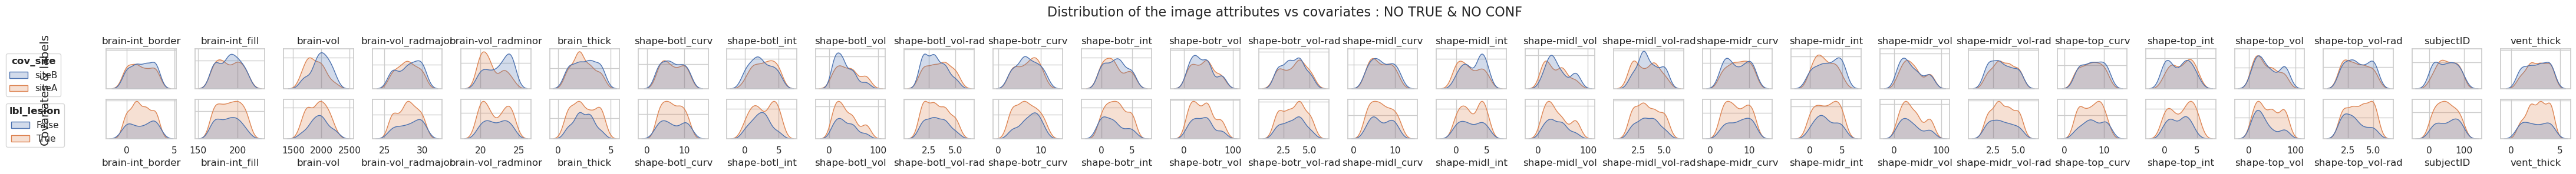

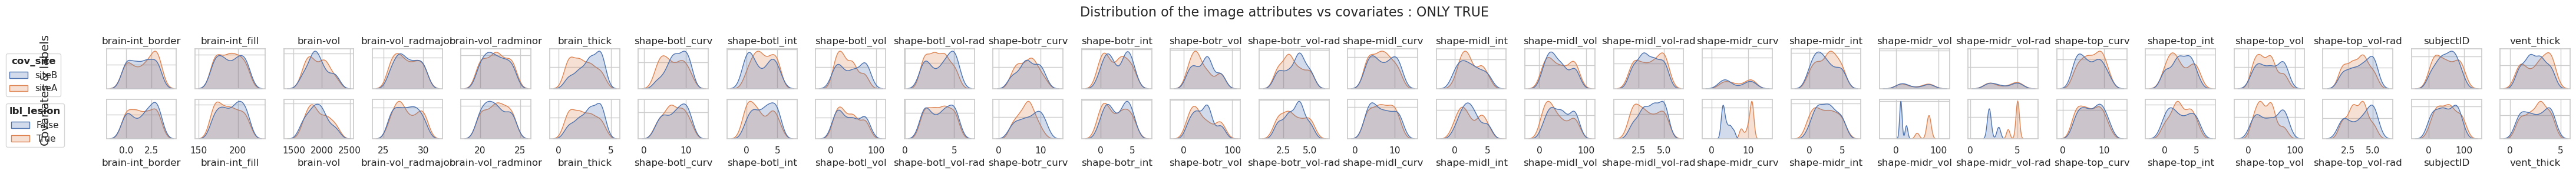

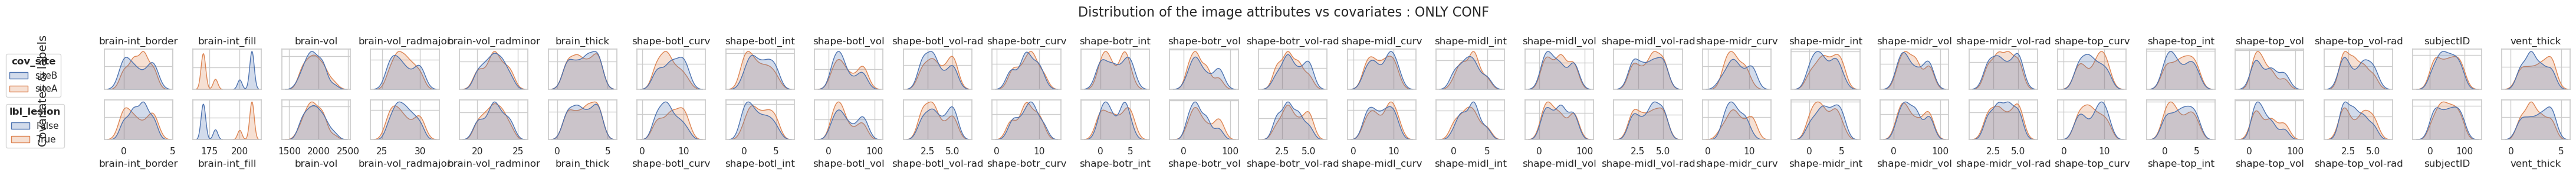

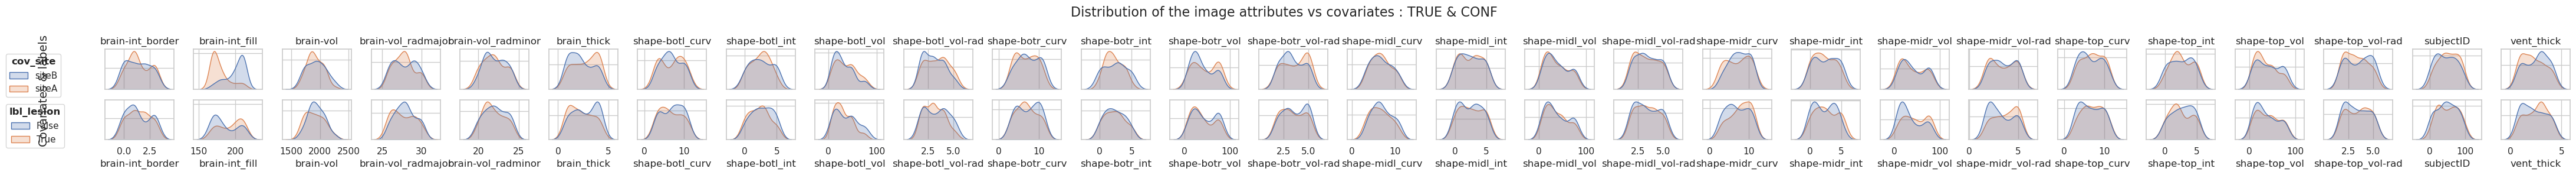

In [ ]:
if VIZ_GENERATED_DISTS: 
    from utils.vizutils import plot_col_dists

    for data, (cy,cX,yX) in [('no true & no conf', ('000','000','000')), 
                ('only true', ('000','000','100')),
                ('only conf', ('100','100','000')),
                ('true & conf', ('050','050','025'))]:
        
        df = pd.read_csv(f'dataset/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}.csv') 
        cov_cols = df.filter(regex='^(cov_|lbl_)').columns
        attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
        plot_col_dists(df, 
                    attr_cols=attr_cols, 
                    cov_cols=cov_cols, 
                    title=f"Distribution of the image attributes vs covariates : {data.upper()}")
        plt.show()

#### See the configured associations (CA)

In [ ]:
if VIZ_BASELINE:
    metric_name = 'balanced_accuracy'
    # load all baseline results
    bl_results = [pd.read_csv(f) for f in glob(f'dataset/toybrains_n{N_SAMPLES}_{basefilename}*/baseline_results/LR/default/run.csv')]
    print(f'Found {len(bl_results)} baseline result tables.')

    # load it all in a dataframe
    df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion'],
                             'inp':['attr_all', 'attr_brain-int_fill', 'attr_shape-midr_curv, shape-midr_vol-rad']},
                filter_cols=[f'score_test_{metric_name}']
                )
    df_model = df_model.data.unstack(level='inp').reset_index(level=["out", "trial"], drop=True)
    # drop the top level of the column index
    df_model.columns = df_model.columns.droplevel()

    df_model = df_model.rename(columns={'attr_all': r'$CA_{total}$', 
                                        'attr_brain-int_fill':r'$CA_{conf}$', 
                                        'attr_shape-midr_curv, shape-midr_vol-rad':r'$CA_{true}$'})
    cmap = {r'$CA_{total}$':'steelblue',
            r'$CA_{conf}$':'indianred',
            r'$CA_{true}$':'forestgreen'}
        
    display(df_model.info())
    display(df_model.tail())

Found 0 baseline result tables.


ValueError: No objects to concatenate

In [ ]:
if VIZ_BASELINE:
    # plot the configured associations for all datasets
    viz_contrib_table_2(df_model, metric_name=metric_name, cmap=cmap,
                        title=f'Configured associations (CA)')
    plt.show()

NameError: name 'df_model' is not defined

In [ ]:
# plot baseline results if generated
if VIZ_BASELINE:
    metric_name = 'r2'

    # load all baseline results
    bl_results = [pd.read_csv(f) for f in glob(f'dataset/toybrains_n{N_SAMPLES}_{basefilename}*/baseline_results/LR/default/run.csv')]
    print(f'Found n={len(bl_results)} baseline results.')

    # load it all in a dataframe
    df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion'], 
                             'inp':['attr_all', 'attr_brain-int_fill', 'attr_shape-midr_curv, shape-midr_vol-rad']},
                filter_cols=[f'score_test_{metric_name}']
                )
    df_model = df_model.data.unstack(level='inp').reset_index(level=["out", "trial"], drop=True)
    # drop the top level of the column index
    df_model.columns = df_model.columns.droplevel()
    df_model = df_model.rename(columns={'attr_all': r'$CA_{total}$', 
                                        'attr_brain-int_fill':r'$CA_{conf}$', 
                                        'attr_shape-midr_curv, shape-midr_vol-rad':r'$CA_{true}$'})    
    
    cmap={r'$CA_{total}$':'steelblue', r'$CA_{conf}$':'indianred',  r'$CA_{true}$':'forestgreen'}

    # display(df_model.info())  
    # display(df_model.tail(10))    
    
    # plot the configured associations for all datasets
    viz_contrib_table_2(df_model, metric_name=metric_name, cmap=cmap,
                        title=f'Configured associations (CA)')
    plt.show()

Found n=0 baseline results.


ValueError: No objects to concatenate

In [ ]:
td = datetime.now()-start_time
print("Notebook finished in {}min : {}sec".format(td.seconds//60, td.seconds%60))

Notebook finished in 39min : 12sec
